<a href="https://colab.research.google.com/github/ctkakau/DATA471_A4/blob/main/DATA471_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA471 Assignment 4
Due 23 September 2022

Chad Kakau: 300212228

In [1]:
# import libraries
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, ElasticNet
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score
from sklearn.metrics import plot_roc_curve, classification_report, f1_score, precision_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
from google.colab import files
import io

In [2]:
train_url = "https://raw.githubusercontent.com/ctkakau/DATA471_A4/main/A4_data_train.csv"
test_url = "https://raw.githubusercontent.com/ctkakau/DATA471_A4/main/A4_data_test.csv"

## Develop a machine learning model to predict the probability of an individual having or using a bank account.  

Train the model on train.csv data and test on test.csv

### import datasets
import uploaded .csv files.

In [3]:

# import data
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# identify target column
Target column: 'bank_account'

# initial EDA
Train data features:
- the train data set has 5627 instances, with 11 features
- the data set has 2 numeric features ('household_size', 'age_of_respondent')
- most categoric features can be encoded (i.e. a reasonable number of categories), but will not encode 'uniqueid' as the individual id.  
- 'household_size' has 567 null instances which will need to be handled 
- the target feature is a 'bank_account', which takes a binary value

In [4]:
print("train dataset has the shape: ", train.shape)
print("\ntrain dataset has these columns: \n", train.columns.values)
print("\ntrain dataset has these data types: \n", train.dtypes)
print("\nsummary of numeric features: \n", train.describe())
print("\nnumber of null features in train dataset: \n", train.isnull().sum())

train dataset has the shape:  (5627, 11)

train dataset has these columns: 
 ['uniqueid' 'bank_account' 'location_type' 'cellphone_access'
 'household_size' 'age_of_respondent' 'gender_of_respondent'
 'relationship_with_head' 'marital_status' 'education_level' 'job_type']

train dataset has these data types: 
 uniqueid                   object
bank_account               object
location_type              object
cellphone_access           object
household_size            float64
age_of_respondent           int64
gender_of_respondent       object
relationship_with_head     object
marital_status             object
education_level            object
job_type                   object
dtype: object

summary of numeric features: 
        household_size  age_of_respondent
count     5060.000000        5627.000000
mean         2.349605          38.425626
std          1.258499          16.339175
min          1.000000          16.000000
25%          2.000000          26.000000
50%          2.000000 

We can check how many values each categoric feature holds and identify which features are suitable for encoding.

In [5]:
# function to check for levels in each categoric feature
def check_levels(df):

  levels = []
  cols = df.columns.values
  
  for col in cols:
    lev = df[col].unique()

    levels.append(lev)

    print("{} has {} levels: \n{}".format(col, len(lev), lev))
  
  return levels

In [6]:
# exclude unwanted categoric (unique_id) and both numeric features
train_levels = check_levels(train)

uniqueid has 5627 levels: 
['uniqueid_3134' 'uniqueid_1531' 'uniqueid_1180' ... 'uniqueid_5076'
 'uniqueid_1653' 'uniqueid_2107']
bank_account has 2 levels: 
['No' 'Yes']
location_type has 2 levels: 
['Urban' 'Rural']
cellphone_access has 2 levels: 
['No' 'Yes']
household_size has 13 levels: 
[ 2.  3.  4.  5. nan  1.  6.  7. 11.  8.  9. 10. 14.]
age_of_respondent has 82 levels: 
[ 20  34  27  63  21  26  52  36  19  43  45  57  30  23  35  51  16  24
  58  40  46  25  38  31  32  42  17  18  75  80  37  70  29  33  47  67
  66  22  44  28  50  60  82  49  39  85  76  55  53  54  56  48  68  83
  59  41  73  65  64  78  62  87  69  61  92  77  81  72  74  71  90  94
  95  88  84  96 100  89  91  86  79  98]
gender_of_respondent has 2 levels: 
['Female' 'Male']
relationship_with_head has 6 levels: 
['Spouse' 'Head of Household' 'Parent' 'Other relative' 'Child'
 'Other non-relatives']
marital_status has 4 levels: 
['Single/Never Married' 'Married/Living together' 'Divorced/Seperated'
 'W

We confirm that all categoric features except 'unique_id' are suitable for encoding.  We also note that 'househod_size' has 13 levels, including 'nan'.

We can begin preprocessing the data by first encoding categoric features and then treating the missing values in 'household_size'.  At around 10% of our dataset, we should be able to develop a suitable model without these instances, but the 'nan' may itself represent something of significance (e.g. a broken step in the collection or recording process) so we will develop two datasets - one with these instances removed, and one where the 'nan' values are imputed.

### Set up a pipeline to manage the pre-processing task and classification task

1. split data into X (features) and y (labels)
2. encode y datasets
3. split X and y into training and testing sets
4. call models
5. create pipeline
6. run gridsearch on five ML models
7. select three best (that I like?), tune hyper parameters
8. develop an ensemble model from those three
9. test the four models (three plus ensemble), report the AUC-ROC and four other metrics; plot ROCs for data (single plot)
10. discuss: learnings, difficulties, future directions

[this pipeline developed from the tutorial at: https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/]


1. create a function to split training into features and class labels.
Call the function, remove 'uniqueid' as it is an arbitrary reference feature and does not offer any predictive value.

In [7]:
# create function to split dataset into X (features) and y (labels)
def make_X_and_y(df, y, removals = []):
  
  # add class label to other columns to be removed from df
  removals.append(y)
  # define y and x
  y = df.loc[:, y]
  x = df.drop(removals, axis = 'columns', )

  return x, y

In [8]:
# establish x and y datasets
x, y = make_X_and_y(train, 'bank_account', ['uniqueid'])

2. create function to encode the target feature and call the function.

In [9]:
# create a function to encode the label
def encode_y(y):

  enc_y = LabelEncoder()
  y = enc_y.fit_transform(np.ravel(y))

  return y

In [10]:
# call the function on the 'bank_account' (y) data set to encode
y = encode_y(y)

3. create function to split data into trainng and test sets, call the function.

In [11]:
# create function to split into train and test data
def split_data(X, y, test_size = 0.3, random_state = 42):

  x_train, x_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size = test_size,
      random_state = random_state
  )

  return x_train, x_test, y_train, y_test

In [12]:
# split into test and train sets, with a 50% split and random seed of 421
x_train, x_test, y_train, y_test = split_data(x, y, 0.5, 421)

4. list the machine learning models for checking later

These models were selected to develop a comparison, so there is no particular preference for any of the methods.  

In [13]:
# call ML models with default hyperparams
params_grid_default = [
    {'estimator': [SVC()]},
    {'estimator': [LogisticRegression()]},
    {'estimator': [KNeighborsClassifier()]},
    {'estimator': [GaussianNB()]},
    {'estimator': [DecisionTreeClassifier()]},
    {'estimator': [SGDClassifier()]},
    {'estimator': [MLPClassifier()]}    
]

5. create a pipeline to:
  - encode categoric features
  - impute missing values (np.nan), using mean
  - scale features using standard scaler
  - select the best features
  - run an estimator (initialise as SVC())

In [14]:
# create the pipeline
# or data needs imputing nan values and encoding categoric variables
pipe = Pipeline([
    ('encoding', OneHotEncoder(handle_unknown = 'ignore', sparse = False)),
    ('imputer', SimpleImputer(missing_values = np.nan, strategy = "mean")),
    ('scaler', StandardScaler(with_mean = False)),
    ('selector', SelectKBest()),
    ('estimator', SVC()),
    ])

Establish scoring methods:

[This information from the sklearn documentation pages:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html] 

The primary scoring method is Receiver Operating Characteristic curve (ROC) and measuring the Area Under the Curve (AUC), representing the performance of the classification model across all classification thresholds and is intuitively, the probability that a model will correctly classify that a person holds a bank account.
We also include:
  - accuracy - is the ability of the classifier to correctly predict either target label; chosen as an overall measure of performance
  - precision - is the ability of the classifier not to label a non-account holder as an account-holder; chosen as a measure to check sensitivity
  - recall - is the ability of the classifier to find all of the target label (e.g. all the account holders, or all of the non-account holders)
  - f1 - harmonic mean of the precision and recall; chosen to see the combination of precision and recall
  - f1_weighted - weighted harmonic mean of the precision and recall

In [15]:
# establish scoring methods
scoring = ['roc_auc',
           'accuracy',
           'precision',
           'recall',
           'f1',
           'f1_weighted']

... then create a function to take in pipeline, parameters (i.e. estimators and parameters for checking), scorers, x (feature) data, y (label) data, and primary scoring method (refit).  make the function output performance summaries for each estimator.

In [16]:
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
# create a function to input pipeline, models, scorer and output 
def all_the_models(pipeline, params, scorer, x, y, x_test, y_test, refit = 'roc_auc'):
  grid_set = []
  results_set = []
  clas_set = []
  from_est_set = []
  prec_rec_disp_set = []

  n = len(pipeline)-1 # last item in pipeline is esitamtor

  # iterate through each param using grid search
  for para in params:

    print("\n======",list(para.values())[0],"======\n")
    grid = GridSearchCV(pipeline, para, scoring = scorer, refit = refit).fit(x, y)  
    grid_set.append(grid)

    # print results of gridsearch
    results = pd.DataFrame(grid.cv_results_)
    # print("Results of {} \n{}".format(list(para.values())[0], results))
    results_set.append(results)

    # print results of each param grid search
    clas = classification_report(y, grid.best_estimator_.predict(x))
    print("Classification report: \n {}".format(clas))
    clas_set.append(clas)


    # ROC plot
    from_est = RocCurveDisplay.from_estimator(grid, x_test, y_test)
    plt.title('ROC_AUC curve from estimates {}'.format(list(para.values())[0]))
    plt.show()

    prec_rec_disp = PrecisionRecallDisplay.from_estimator(grid, x_test, y_test)
    plt.title('Precision-Recall curve: {}'.format(list(para.values())[0]))
    plt.show()

    from_est_set.append(from_est)
    prec_rec_disp_set.append(prec_rec_disp)

    # print best estimator and and value
    print("The best estimator is:\n{}".format(grid.best_estimator_[4]))
    print("AUC_ROC score for %s is %f.3" % (grid.best_estimator_[4], grid.best_score_))
    
    # output the model for prediction
  return grid_set, clas_set, results_set

6. run the function against the default pipeline and eight ML methods, scoring against the 'roc_auc' metric.  We retain the default cross-validation k = 5 for gridsearchCV.


====== [SVC()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      2568
           1       0.86      0.36      0.51       245

    accuracy                           0.94      2813
   macro avg       0.90      0.68      0.74      2813
weighted avg       0.94      0.94      0.93      2813



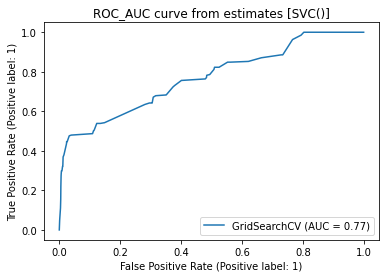

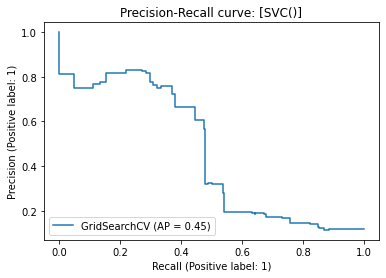

The best estimator is:
SVC()
AUC_ROC score for SVC() is 0.750290.3

====== [LogisticRegression()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2568
           1       0.74      0.41      0.53       245

    accuracy                           0.94      2813
   macro avg       0.84      0.70      0.75      2813
weighted avg       0.93      0.94      0.93      2813



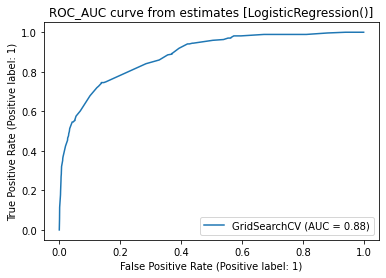

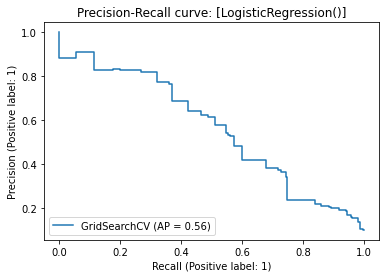

The best estimator is:
LogisticRegression()
AUC_ROC score for LogisticRegression() is 0.903551.3

====== [KNeighborsClassifier()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      2568
           1       0.70      0.42      0.53       245

    accuracy                           0.93      2813
   macro avg       0.82      0.70      0.75      2813
weighted avg       0.93      0.93      0.93      2813



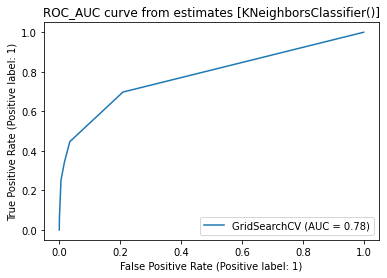

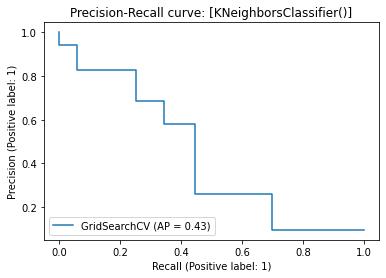

The best estimator is:
KNeighborsClassifier()
AUC_ROC score for KNeighborsClassifier() is 0.798625.3

====== [GaussianNB()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      2568
           1       0.37      0.72      0.49       245

    accuracy                           0.87      2813
   macro avg       0.67      0.80      0.71      2813
weighted avg       0.92      0.87      0.89      2813



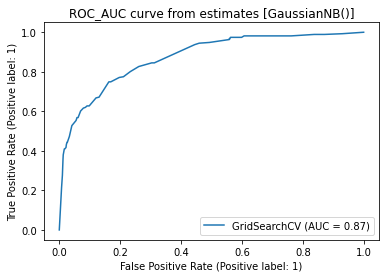

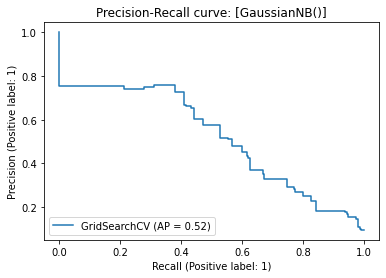

The best estimator is:
GaussianNB()
AUC_ROC score for GaussianNB() is 0.901746.3

====== [DecisionTreeClassifier()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2568
           1       0.81      0.41      0.55       245

    accuracy                           0.94      2813
   macro avg       0.88      0.70      0.76      2813
weighted avg       0.93      0.94      0.93      2813



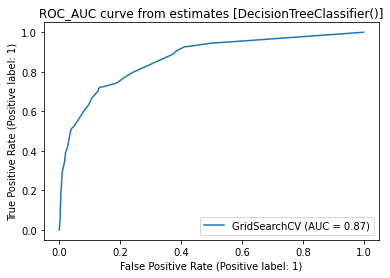

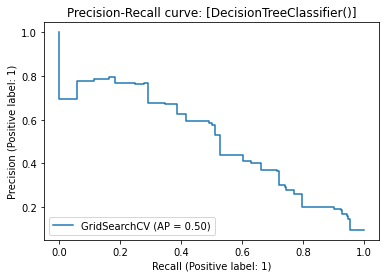

The best estimator is:
DecisionTreeClassifier()
AUC_ROC score for DecisionTreeClassifier() is 0.882461.3

====== [SGDClassifier()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      2568
           1       0.68      0.42      0.52       245

    accuracy                           0.93      2813
   macro avg       0.81      0.70      0.74      2813
weighted avg       0.92      0.93      0.92      2813



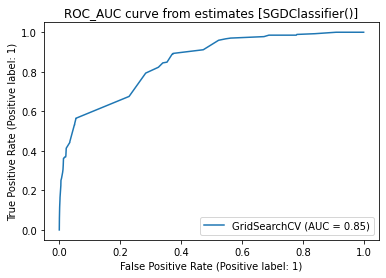

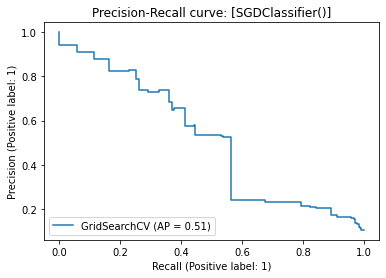

The best estimator is:
SGDClassifier()
AUC_ROC score for SGDClassifier() is 0.872580.3

====== [MLPClassifier()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2568
           1       0.88      0.34      0.49       245

    accuracy                           0.94      2813
   macro avg       0.91      0.67      0.73      2813
weighted avg       0.94      0.94      0.93      2813



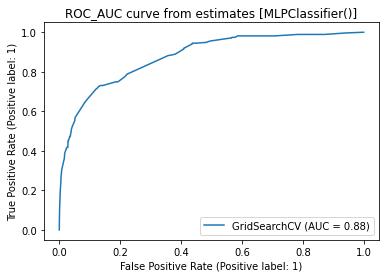

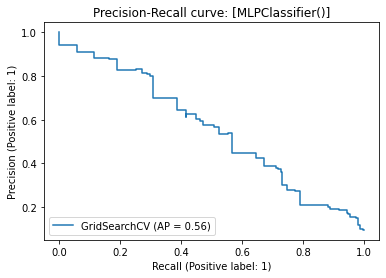

The best estimator is:
MLPClassifier()
AUC_ROC score for MLPClassifier() is 0.901664.3


In [17]:
default_models = all_the_models(pipe, params_grid_default, scoring, x_train, y_train, x_test, y_test)

Results show that Logistic Regression, SGD, and MLP had the best performance with AUC_ROC score of 0.88, under default parameters. 

We can see that support for both non-account-holders is much higher (2568 instances) than for account holders (245), which raises the issue of class imbalance whoch could be resolved by weighting the impact of each class(currently a difference at a scale of 10)

We will use these three models for further tuning of hyper parameters.

In [18]:
# range of hyper-parameters
params_grid = [
    {'estimator': [LogisticRegression()],
      'estimator__C': [0.1, 1, 10,]},
      {'estimator': [SGDClassifier(loss = 'log')],
       'estimator__penalty': ['l2', 'l1', 'elasticnet']},
       {'estimator': [MLPClassifier()],
         'estimator__hidden_layer_sizes': [(4, 8, 4), (8, 6), (5, 5, 10, 2)]}
]


In [19]:
# create a new pipeline
# or data needs imputing nan values and encoding categoric variables
tuned_pipe = Pipeline([
    ('encoding', OneHotEncoder(handle_unknown = 'ignore', sparse = False)),
    ('imputer', SimpleImputer(missing_values = np.nan, strategy = "mean")),
    ('scaler', StandardScaler(with_mean = False)),
    ('selector', SelectKBest(k=7)),
    ('estimator', SVC()),
    ])


====== [LogisticRegression()] ======

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      2568
           1       0.75      0.38      0.50       245

    accuracy                           0.93      2813
   macro avg       0.85      0.68      0.73      2813
weighted avg       0.93      0.93      0.92      2813



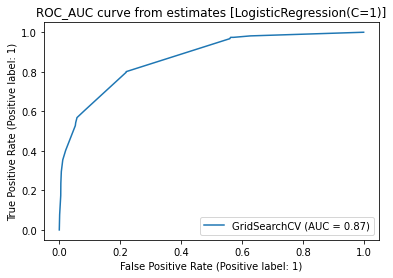

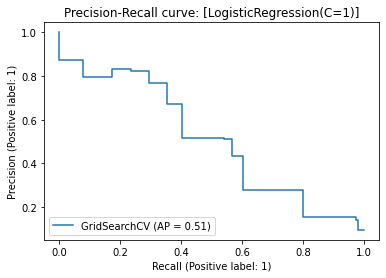

The best estimator is:
LogisticRegression(C=1)
AUC_ROC score for LogisticRegression(C=1) is 0.895872.3

====== [SGDClassifier(loss='log')] ======



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      2568
           1       0.69      0.42      0.52       245

    accuracy                           0.93      2813
   macro avg       0.82      0.70      0.74      2813
weighted avg       0.92      0.93      0.93      2813



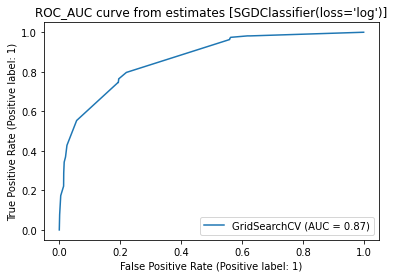

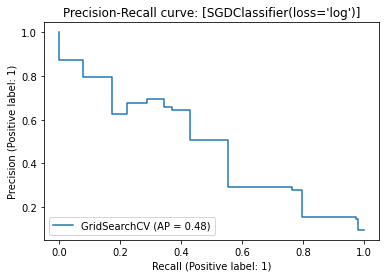

The best estimator is:
SGDClassifier(loss='log')
AUC_ROC score for SGDClassifier(loss='log') is 0.893554.3

====== [MLPClassifier()] ======



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      2568
           1       0.75      0.38      0.50       245

    accuracy                           0.93      2813
   macro avg       0.85      0.68      0.73      2813
weighted avg       0.93      0.93      0.92      2813



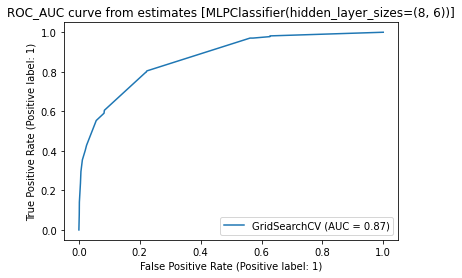

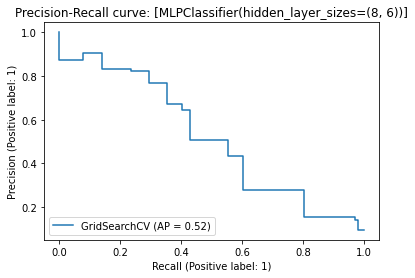

The best estimator is:
MLPClassifier(hidden_layer_sizes=(8, 6))
AUC_ROC score for MLPClassifier(hidden_layer_sizes=(8, 6)) is 0.894434.3


In [20]:
tuning_models = all_the_models(tuned_pipe, params_grid, scoring, x_train, y_train, x_test, y_test)

After running gridsearchCV on parameters for each model we find the best performing model and parameter combinations:

LogisticRegression(C=1)
SGDClassifier(penalty = 'elasticnet')
MLPClassifier(hidden_layer_sizes = (8, 6))

We see the following scores:

LogisticRegression(C = 1):0.895 ROC_AUC, followed closely by 
MLPClassifier(hidden_layer_sizes = (8, 6)): 0.896 ROC_AUC, and then
SGDClassifier(penalty = 'l1'): 0.878 ROC_AUC

We also see precision, recall, f1 and accuracy scores for each model.  

If our primary performance metric is ROC_AUC then the best classifier is MLPClassifier([8, 6])the neural net with 2 latent layers containing 8 and 6 nodes respectively.  

If our pirmary performance metric is Sensitivity (TPR) (proportion of correctly classified bank-account-holders) then we take the model with the best recall for label = 1:  
SGDClassifier, at 0.46

If our primary performance metric is Specificity (TNR) (proportion of correctly classified non-bank-account-holders) then we take the model with the best recall for label = 0:  
LogisticRegression(C=1) and MLPClassifier([8, 6]) at 0.99

If our primary performance metric is Accuracy (proportion of correctly classified labels) then we take the model with the best accuracy:  
MLPClassifier(hidden_layer_sizes = (8, 6)) at 0.94



Create an ensemble using these models and the best performing parameters:

LogisticRegression(C = 1)  
SGDClassifier(penalty = 'elasticnet')  
MLPClassifier([8, 6])  

We will use the sci-kit-learn VotingClassifier function to build the ensemble model.



In [21]:
# collect the best estimators
lr = tuning_models[0][0].best_estimator_
sgd = tuning_models[0][1].best_estimator_
mlp = tuning_models[0][2].best_estimator_

In [22]:
# create the dictionary of models
# method from https://towardsdatascience.com/ensemble-learning-using-scikit-learn-85c4531ff86a
estimators =[('logistic_regression', lr), ('SGD', sgd), ('MLP', mlp)]

# create the voting classifier
ensemble = VotingClassifier(estimators, voting = 'soft')

# fit the model to the training data
ensemble.fit(x_train, y_train)

# and test the model on the test data
ensemble.score(x_test, y_test)

0.9275053304904051

The ensemble method (using Voting Classifier) predicts the class label based on the majority prediction from the contributing models (Logistic Regression, Stochastic Gradient Descent, and Multi-layer perceptron).  The mean accuracy of the ensemble method is around 93%

In [23]:
# load all the models as params
final_params = [
    {'estimator': [LogisticRegression(C=1)]},
    {'estimator': [SGDClassifier(penalty = 'elasticnet')]},
    {'estimator': [MLPClassifier(hidden_layer_sizes = (8, 6))]}]

In [24]:
from sklearn.metrics import plot_roc_curve

# run each model and collect results for plotting
def single_models(pipeline, params, scorer, x_train, y_train, x_test, y_test, ensemble, refit = 'roc_auc'):

  # fig = plt.figure()
  # plt.title('ROC_AUC curves')
  ax = plt.gca()
  ax.set_title("ROC curves for three individual models")
   
  grid_set = []
  
  for para in params:
    grid = GridSearchCV(pipeline, para, scoring = scorer, refit = refit).fit(x_train, y_train)  
    grid_set.append(grid)
    
    print("\n===== {} ====\n".format(grid.best_estimator_[4]))
    print("AUC_ROC score for %s is %f.3" % (grid.best_estimator_[4], grid.best_score_))
    print(classification_report(y_test, grid.best_estimator_.predict(x_test)))

    est = list(para.values())[0]

    plot_roc_curve(grid, x_test, y_test, ax = ax, label = "ROC: {}".format(para['estimator']))
    

  plot_roc_curve(ensemble, x_test, y_test, ax = ax, label = "ROC: ensemble")
  plt.show()


===== LogisticRegression(C=1) ====

AUC_ROC score for LogisticRegression(C=1) is 0.895872.3
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2543
           1       0.77      0.35      0.48       271

    accuracy                           0.93      2814
   macro avg       0.85      0.67      0.72      2814
weighted avg       0.92      0.93      0.92      2814



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)



===== SGDClassifier(penalty='elasticnet') ====

AUC_ROC score for SGDClassifier(penalty='elasticnet') is 0.841707.3
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2543
           1       0.66      0.37      0.47       271

    accuracy                           0.92      2814
   macro avg       0.80      0.67      0.71      2814
weighted avg       0.91      0.92      0.91      2814



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



===== MLPClassifier(hidden_layer_sizes=(8, 6)) ====

AUC_ROC score for MLPClassifier(hidden_layer_sizes=(8, 6)) is 0.894832.3
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2543
           1       0.76      0.32      0.45       271

    accuracy                           0.92      2814
   macro avg       0.84      0.66      0.71      2814
weighted avg       0.91      0.92      0.91      2814



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


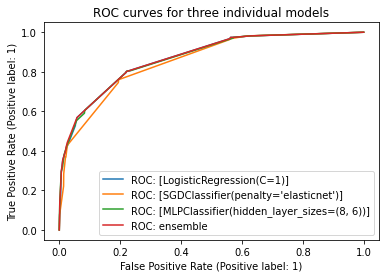

In [25]:
single_models(tuned_pipe, final_params, scoring, x_train, y_train, x_test, y_test, ensemble)

Performance across all four models is very similar, it is difficult to visually see the difference between any of the models in the plot.  There are differences between the models across most of the performance metrics but those differences are small.





# Discussion
Using sci-kit-learn python package was really useful for pulling together lots of functions and processes, including building pipelines for pre-processing data, running machine learning methods and outputting useful results.  Obviously it takes a bit of practice but with a bit of time in the documentation the package is incredibly powerful.  

The methods used in this project were fairly straightforward, often selected for convenience (i.e. minimum preparation for use in pipelines or gridsearch etc.) so may not have produced the best possible results, but as a demonstration of the convenience and power of an automated pipeline, and model selection tool, it is a super powerful package.

In future I would have more time because I'm magic and can make time.  I'd like to try a few more of the pre-processing tools and perhaps do something more indepth with a handful of the machine learning methods (e.g. how deep into MLP can I go - as far as pytorch etc.).

Most of the time, the problems I had in this project were mundane - using sparse matrices with methods that required dense, or using methods that can't produce probability estimates etc.  Although the problems were mundane, the solutions weren't always easy to find on the internet so they still presented challenges. 